## Sentiment Analysis: Build a Movie Review Classifier
Let's build a complete sentiment analysis system that can classify text as positive or negative, and deploy it as a web application. We'll use the IMDB movie reviews dataset and create a production-ready model.

In [1]:
# Install required packages
# pip install tensorflow pandas numpy matplotlib seaborn streamlit plotly wordcloud scikit-learn nltk

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

# Download NLTK Data

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("✅ NLTK resources downloaded")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


✅ NLTK resources downloaded


# Load and Explore the Dataset

In [3]:
def load_imdb_data():
    """
    Load IMDB movie reviews dataset
    """
    # For this example, we'll create a sample dataset
    # In practice, we are to load from actual IMDB dataset
    sample_reviews = [
        ("This movie was absolutely fantastic! I loved every moment of it.", 1),
        ("One of the worst films I've ever seen. Terrible acting and plot.", 0),
        ("Brilliant cinematography and outstanding performances by the cast.", 1),
        ("Boring and predictable. Waste of time and money.", 0),
        ("The director did an amazing job with character development.", 1),
        ("Poor script and awful dialogue. Couldn't finish watching.", 0),
        ("A masterpiece that will be remembered for years to come.", 1),
        ("Disappointing and overrated. Don't believe the hype.", 0),
        ("The special effects were mind-blowing and revolutionary.", 1),
        ("Slow pacing and confusing storyline. Hard to follow.", 0)
    ]

    # Create DataFrame
    df = pd.DataFrame(sample_reviews, columns=['review', 'sentiment'])

    # For a real project, We are to use:
    # from tensorflow.keras.datasets import imdb
    # (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

    return df

# Load data
df = load_imdb_data()
print("📊 Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Positive reviews: {df['sentiment'].sum()}")
print(f"Negative reviews: {len(df) - df['sentiment'].sum()}")
print("\nSample reviews:")
print(df.head())

📊 Dataset loaded successfully!
Dataset shape: (10, 2)
Positive reviews: 5
Negative reviews: 5

Sample reviews:
                                              review  sentiment
0  This movie was absolutely fantastic! I loved e...          1
1  One of the worst films I've ever seen. Terribl...          0
2  Brilliant cinematography and outstanding perfo...          1
3   Boring and predictable. Waste of time and money.          0
4  The director did an amazing job with character...          1


# Text Preprocessing & Feature Engineering

In [4]:
class TextPreprocessor:
    """Text preprocessing pipeline for sentiment analysis"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean and preprocess text"""
        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Remove punctuation and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def remove_stopwords(self, text):
        """Remove stopwords from text"""
        words = text.split()
        filtered_words = [word for word in words if word not in self.stop_words]
        return ' '.join(filtered_words)

    def lemmatize_text(self, text):
        """Lemmatize words in text"""
        words = text.split()
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    def preprocess(self, texts):
        """Apply full preprocessing pipeline"""
        cleaned_texts = []

        for text in texts:
            # Apply all preprocessing steps
            cleaned = self.clean_text(text)
            cleaned = self.remove_stopwords(cleaned)
            cleaned = self.lemmatize_text(cleaned)
            cleaned_texts.append(cleaned)

        return cleaned_texts

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Preprocess the data
df['cleaned_review'] = preprocessor.preprocess(df['review'])
print("✅ Text preprocessing completed!")
print("\nOriginal vs Cleaned:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i][:50]}...")
    print(f"Cleaned: {df['cleaned_review'].iloc[i][:50]}...")
    print("-" * 50)

✅ Text preprocessing completed!

Original vs Cleaned:
Original: This movie was absolutely fantastic! I loved every...
Cleaned: movie absolutely fantastic loved every moment...
--------------------------------------------------
Original: One of the worst films I've ever seen. Terrible ac...
Cleaned: one worst film ive ever seen terrible acting plot...
--------------------------------------------------
Original: Brilliant cinematography and outstanding performan...
Cleaned: brilliant cinematography outstanding performance c...
--------------------------------------------------


## Text Visualization & Analysis

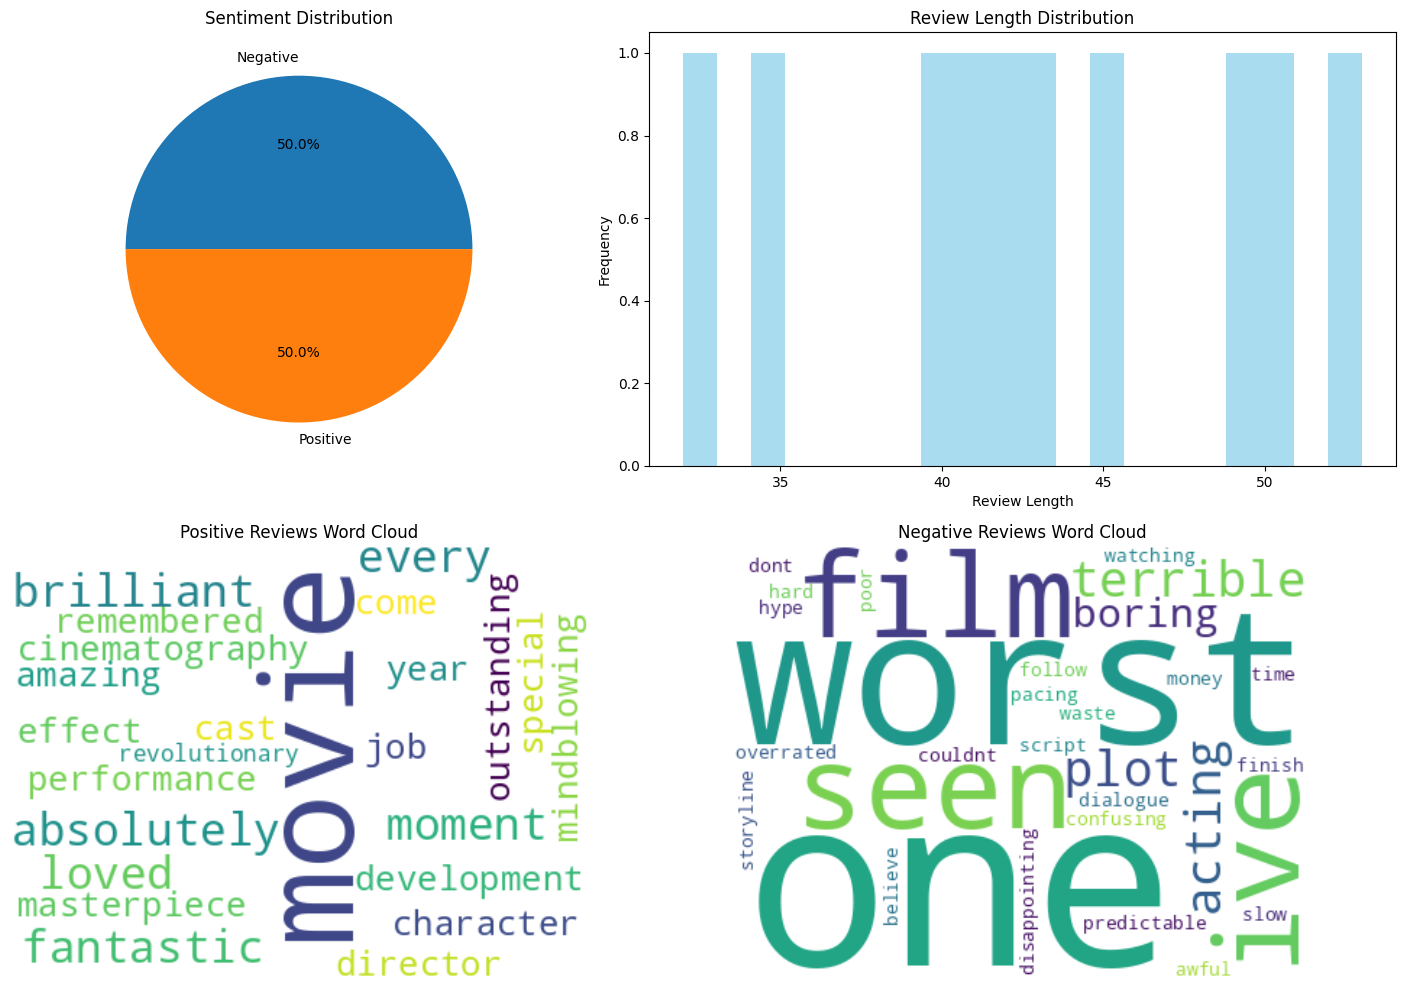

📊 Text Analysis Statistics:
Average review length: 43.00 characters
Total unique words: 56
Most common words: [('movie', 1), ('absolutely', 1), ('fantastic', 1), ('loved', 1), ('every', 1)]


In [5]:
def analyze_text_data(df):
    """Analyze and visualize text data"""

    # Word frequency analysis
    all_words = ' '.join(df['cleaned_review']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()
    axes[0, 0].pie(sentiment_counts.values, labels=['Negative', 'Positive'], autopct='%1.1f%%')
    axes[0, 0].set_title('Sentiment Distribution')

    # 2. Review length distribution
    df['review_length'] = df['cleaned_review'].apply(len)
    axes[0, 1].hist(df['review_length'], bins=20, alpha=0.7, color='skyblue')
    axes[0, 1].set_title('Review Length Distribution')
    axes[0, 1].set_xlabel('Review Length')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Word cloud for positive reviews
    positive_text = ' '.join(df[df['sentiment'] == 1]['cleaned_review'])
    wordcloud_positive = WordCloud(width=400, height=300, background_color='white').generate(positive_text)
    axes[1, 0].imshow(wordcloud_positive, interpolation='bilinear')
    axes[1, 0].set_title('Positive Reviews Word Cloud')
    axes[1, 0].axis('off')

    # 4. Word cloud for negative reviews
    negative_text = ' '.join(df[df['sentiment'] == 0]['cleaned_review'])
    wordcloud_negative = WordCloud(width=400, height=300, background_color='white').generate(negative_text)
    axes[1, 1].imshow(wordcloud_negative, interpolation='bilinear')
    axes[1, 1].set_title('Negative Reviews Word Cloud')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("📊 Text Analysis Statistics:")
    print(f"Average review length: {df['review_length'].mean():.2f} characters")
    print(f"Total unique words: {len(word_freq)}")
    print(f"Most common words: {common_words[:5]}")

    return word_freq

# Analyze the data
word_freq = analyze_text_data(df)

#  Build & Train LSTM Model

✅ Data preparation completed!
Training data shape: (8, 200)
Test data shape: (2, 200)
Vocabulary size: 48
🧠 Sentiment Analysis Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

🚀 Training Sentiment Analysis Model...
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.2500 - loss: 0.6929 - precision: 0.2500 - recall: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step - accuracy: 0.2500 - loss: 0.6954 - precision: 0.2500 - recall: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.6930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step - accuracy: 0.8750 - loss: 0.6911 - precision: 0.8000 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.6250 - loss: 0.6930 - precision: 0.6000 - recall: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Ep

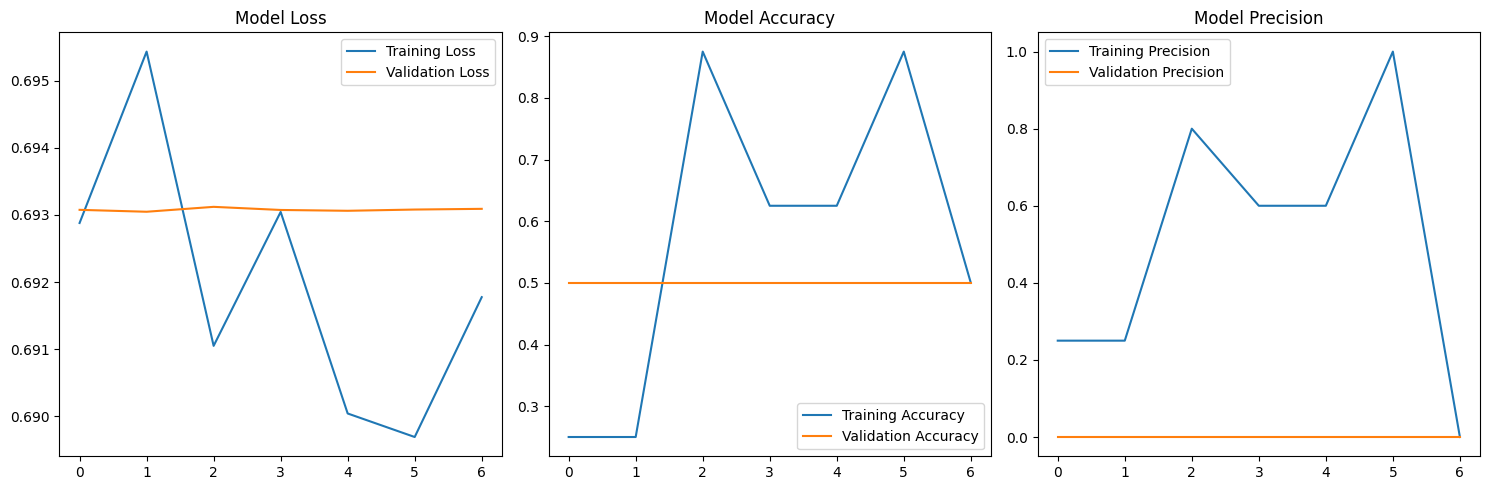

In [6]:
def prepare_data_for_training(df, max_features=10000, max_length=200):
    """
    Prepare text data for LSTM training
    """
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    # Split data
    X = df['cleaned_review'].values
    y = df['sentiment'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Tokenize text
    tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    # Convert to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    print(f"✅ Data preparation completed!")
    print(f"Training data shape: {X_train_pad.shape}")
    print(f"Test data shape: {X_test_pad.shape}")
    print(f"Vocabulary size: {len(tokenizer.word_index)}")

    return X_train_pad, X_test_pad, y_train, y_test, tokenizer, max_length

# Prepare data
X_train, X_test, y_train, y_test, tokenizer, max_length = prepare_data_for_training(df)

def build_sentiment_model(vocab_size, max_length, embedding_dim=100):
    """
    Build LSTM model for sentiment analysis
    """
    model = tf.keras.Sequential([
        # Embedding layer
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            mask_zero=True
        ),

        # Spatial Dropout to prevent overfitting
        tf.keras.layers.SpatialDropout1D(0.2),

        # First LSTM layer
        tf.keras.layers.LSTM(
            64,
            dropout=0.2,
            recurrent_dropout=0.2,
            return_sequences=True
        ),

        # Second LSTM layer
        tf.keras.layers.LSTM(
            32,
            dropout=0.2,
            recurrent_dropout=0.2
        ),

        # Dense layers
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output layer (binary classification)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Build the model
vocab_size = len(tokenizer.word_index) + 1
model = build_sentiment_model(vocab_size, max_length)

print("🧠 Sentiment Analysis Model Architecture:")
model.summary()

# Train the model
def train_sentiment_model(model, X_train, y_train, X_test, y_test, epochs=20):
    """
    Train the sentiment analysis model
    """
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3
        )
    ]

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    return history

print("🚀 Training Sentiment Analysis Model...")
history = train_sentiment_model(model, X_train, y_train, X_test, y_test, epochs=20)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation & Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
📊 Model Evaluation Results:

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         1
    Positive       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


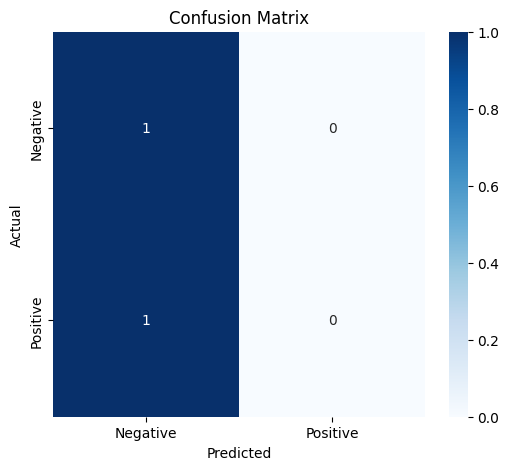

ROC-AUC Score: 1.0000
🧪 Testing Sentiment Analyzer:
Text: This movie is absolutely amazing and fantastic!
Sentiment: Positive (Confidence: 50.02%)
--------------------------------------------------
Text: Terrible acting and boring storyline.
Sentiment: Negative (Confidence: 50.03%)
--------------------------------------------------
Text: It was okay, nothing special.
Sentiment: Negative (Confidence: 50.12%)
--------------------------------------------------
Text: Brilliant cinematography and outstanding performances!
Sentiment: Positive (Confidence: 50.00%)
--------------------------------------------------


In [7]:
def evaluate_model(model, X_test, y_test, tokenizer):
    """
    Evaluate the sentiment analysis model
    """
    # Make predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

    print("📊 Model Evaluation Results:")
    print("=" * 50)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC-AUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {auc_score:.4f}")

    return y_pred, y_pred_proba

# Evaluate the model
y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, tokenizer)

class SentimentAnalyzer:
    """Sentiment analysis pipeline"""

    def __init__(self, model, tokenizer, preprocessor, max_length):
        self.model = model
        self.tokenizer = tokenizer
        self.preprocessor = preprocessor
        self.max_length = max_length

    def predict_sentiment(self, text):
        """Predict sentiment for a single text"""
        # Preprocess text
        cleaned_text = self.preprocessor.preprocess([text])[0]

        # Convert to sequence
        sequence = self.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
            sequence, maxlen=self.max_length, padding='post', truncating='post'
        )

        # Make prediction
        prediction = self.model.predict(padded_sequence, verbose=0)[0][0]
        sentiment = 'Positive' if prediction > 0.5 else 'Negative'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        return {
            'sentiment': sentiment,
            'confidence': float(confidence),
            'score': float(prediction)
        }

    def analyze_batch(self, texts):
        """Analyze sentiment for multiple texts"""
        results = []
        for text in texts:
            result = self.predict_sentiment(text)
            result['text'] = text
            results.append(result)

        return pd.DataFrame(results)

# Initialize sentiment analyzer
sentiment_analyzer = SentimentAnalyzer(model, tokenizer, preprocessor, max_length)

# Test the analyzer
test_texts = [
    "This movie is absolutely amazing and fantastic!",
    "Terrible acting and boring storyline.",
    "It was okay, nothing special.",
    "Brilliant cinematography and outstanding performances!"
]

print("🧪 Testing Sentiment Analyzer:")
print("=" * 50)

for text in test_texts:
    result = sentiment_analyzer.predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Sentiment: {result['sentiment']} (Confidence: {result['confidence']:.2%})")
    print("-" * 50)

## Advanced Features & Analysis

In [10]:
def create_sentiment_dashboard(df, sentiment_analyzer):
    # Analyze sentiment
    df['sentiment'] = df['review_text'].apply(sentiment_analyzer.analyze_sentiment)

    # Group by sentiment
    grouped = df.groupby('sentiment')

    def get_sentiment_stats(sentiment):
        try:
            group = grouped.get_group(sentiment)
            count = len(group)
            avg_rating = group['rating'].mean()
            return count, avg_rating
        except KeyError:
            return 0, 0

    total_positive_reviews, positive_avg_rating = get_sentiment_stats('Positive')
    total_negative_reviews, negative_avg_rating = get_sentiment_stats('Negative')
    total_neutral_reviews, neutral_avg_rating = get_sentiment_stats('Neutral')

    # Create dashboard
    dashboard_data = {
        'Total Positive Reviews': [total_positive_reviews],
        'Total Negative Reviews': [total_negative_reviews],
        'Total Neutral Reviews': [total_neutral_reviews],
        'Average Rating (Positive)': [positive_avg_rating],
        'Average Rating (Negative)': [negative_avg_rating],
        'Average Rating (Neutral)': [neutral_avg_rating]
    }

    return pd.DataFrame(dashboard_data)